## Multivariate Time Series Forecasting with Deep Learning
### Predicting the price of Bitcoin and interpreting the results

This notebook runs the entire forecasting pipeline from data preparation to model training and interpretation.

Alternatively, everything can be run from the terminal as well (see README.md).

Prerequisite: Dataset has been downloaded (see README.md) and parameters have been updated if necessary (see /model/params.yaml).

### Setup

In [14]:
import os
import yaml
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

os.chdir("../scripts")

import preprocess, train, inference, interpret

In [11]:
with open("../model/params.yaml", "r") as params_file:
    params = yaml.safe_load(params_file)

data_dir = params['data_dir']

### Load and Prepare the Data

In [2]:
file_name = "BTC-USD.csv"
data = preprocess.load_data(file_name)
data.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-07-06,670.418030,681.898010,670.418030,677.330994,677.330994,134960992.0
1,2016-07-07,678.090027,682.432007,611.833984,640.562012,640.562012,258091008.0
2,2016-07-08,640.687988,666.706970,636.466980,666.523010,666.523010,141970000.0


In [3]:
train_df, test_df = preprocess.prep_data(df=data, train_frac=0.5, plot_df=True)

Starting with data preparation...
Completed.


In [5]:
train_df.shape, test_df.shape

((911, 7), (911, 7))

### Explore the Data

In [12]:
plot_df = pd.read_csv(Path(data_dir, 'plot_df.csv'))
plot_df['Close_Change'] = plot_df.Close.pct_change(1)
plot_df = plot_df.dropna()

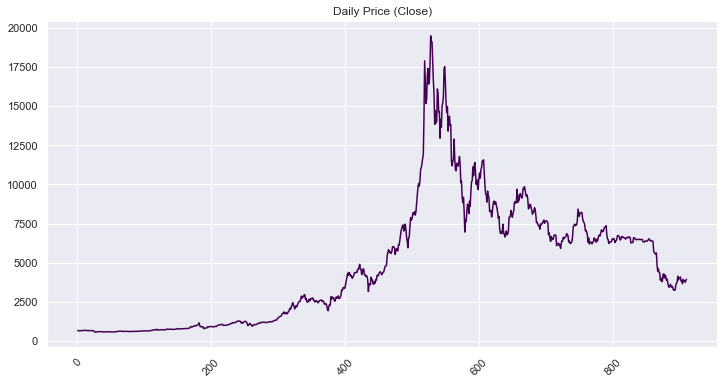

In [15]:
plot_df['Close'].plot(figsize=(12,6), rot=45, cmap='viridis')
plt.title('Daily Price (Close)')
plt.show()

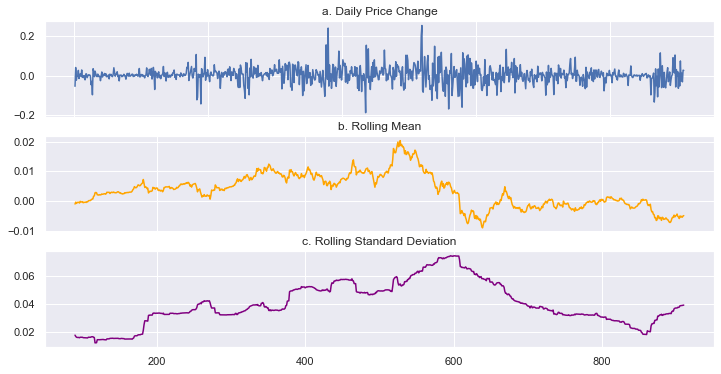

In [16]:
fig, axes = plt.subplots(nrows=3, ncols=1)
plot_df['Close_Change'].plot(ax=axes[0], figsize=(12,6), rot=90, title='a. Daily Price Change', sharex=True)
plot_df['Close_Change'].rolling(90).mean().plot(ax=axes[1], figsize=(12,6), rot=90, title='b. Rolling Mean', color='orange')
plot_df['Close_Change'].rolling(90).std().plot(ax=axes[2], figsize=(12,6), rot=0, title='c. Rolling Standard Deviation', color='purple')
plt.show()

### Train the LSTM model

In [17]:
sequence_length = 30
batch_size = 8
n_epochs = 20
n_epochs_stop = 5
label_name = 'Close'

In [21]:
hist = train.train_model(train_df, test_df, label_name, sequence_length, batch_size, n_epochs, n_epochs_stop)

Starting with model training...
Epoch 1 train loss: 0.0055 test loss: 1.24
Epoch 2 train loss: 0.0185 test loss: 1.1649
Epoch 3 train loss: 0.0311 test loss: 1.1032
Epoch 4 train loss: 0.0397 test loss: 1.0538
Epoch 5 train loss: 0.0403 test loss: 1.0044
Epoch 6 train loss: 0.0401 test loss: 0.9459
Epoch 7 train loss: 0.0372 test loss: 0.8767
Epoch 8 train loss: 0.0338 test loss: 0.7073
Epoch 9 train loss: 0.0269 test loss: 0.5886
Epoch 10 train loss: 0.0265 test loss: 0.4096
Epoch 11 train loss: 0.0187 test loss: 0.3873
Epoch 12 train loss: 0.0146 test loss: 0.3324
Epoch 13 train loss: 0.0098 test loss: 0.3347
Epoch 14 train loss: 0.0086 test loss: 0.2597
Epoch 15 train loss: 0.0071 test loss: 0.2653
Epoch 16 train loss: 0.0069 test loss: 0.269
Epoch 17 train loss: 0.0061 test loss: 0.2958
Epoch 18 train loss: 0.0059 test loss: 0.3499
Early stopping.
Completed.


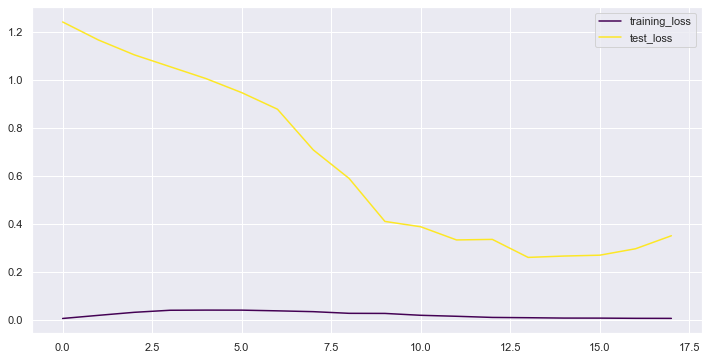

In [22]:
hist.plot(figsize=(12,6), cmap='viridis')
plt.show()

### Evaluate the model

In [23]:
predictions_descaled, labels_descaled = inference.predict(df=test_df,
                                                          label_name='Close',
                                                          sequence_length=sequence_length)

predictions_descaled.shape, predictions_descaled.shape

((881,), (881,))

In [24]:
print('Error on all test data:')
inference.print_loss_metrics(labels_descaled, predictions_descaled)
print('\n')
print('Error on partial test data:')
inference.print_loss_metrics(labels_descaled[:30], predictions_descaled[:30])

Error on all test data:
RMSE:  9452.15
MAE:  6107.52


Error on partial test data:
RMSE:  781.31
MAE:  728.72


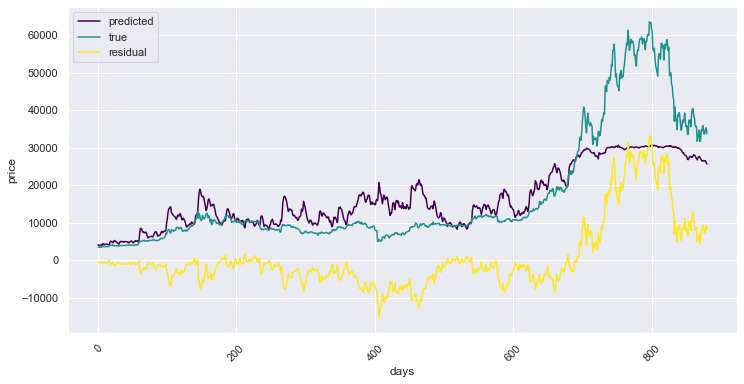

In [25]:
# plot predictions vs true values
df_pred = pd.DataFrame()
df_pred['predicted'] = predictions_descaled
df_pred['true'] = labels_descaled
df_pred['residual'] = labels_descaled - predictions_descaled
df_pred.plot(figsize=(12,6), cmap='viridis')
plt.xticks(rotation=45)
#plt.xlim(0,300)
plt.xlabel('days')
plt.ylabel('price')
plt.legend()
plt.show()

### Find important features

In [ ]:
from train import TimeSeriesDataset, TSModel
from torch.utils.data import DataLoader
import torch
import shap

In [26]:
background_data_size = 900
test_sample_size = 100
sequence_length = 30

In [27]:
shap_values = interpret.get_important_features(
    background_data_size,
    test_sample_size,
    sequence_length
)

Using non-full backward hooks on a Module that does not return a single Tensor or a tuple of Tensors is deprecated and will be removed in future versions. This hook will be missing some of the grad_output. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [28]:
shap_plot = pd.DataFrame(shap_values, columns=train_df.columns.tolist())
shap_plot['days'] = [i-31 for i in list(range(1,31))]
shap_plot.head()

,Close,Volume,High_Low_Pct,Open_Close_Pct,Day_Of_Week,Month_Of_Year,Quarter_Of_Year,days
0,4.536464e-09,1.308553e-09,3.733840e-09,2.277841e-10,5.855153e-09,5.049538e-09,1.111705e-08,-30
1,1.299062e-08,3.230439e-09,7.978107e-09,3.186419e-10,1.103054e-08,1.230902e-08,2.207379e-08,-29
2,2.942053e-08,6.724776e-09,1.539174e-08,3.841993e-10,1.985690e-08,2.498790e-08,4.195253e-08,-28
3,6.048772e-08,1.322252e-08,2.852340e-08,4.409924e-10,3.434911e-08,4.608339e-08,7.675932e-08,-27
4,1.182631e-07,2.511822e-08,5.172206e-08,7.218557e-10,5.741765e-08,8.004698e-08,1.358695e-07,-26


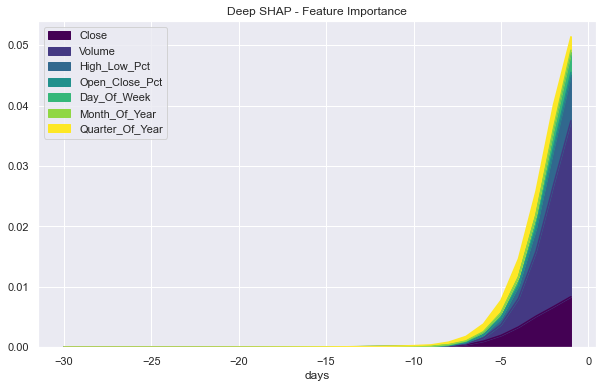

In [29]:
shap_plot.plot.area(x='days',figsize=(10, 6), cmap='viridis')
plt.title("Deep SHAP - Feature Importance")
plt.show()